In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve,
    auc,
    confusion_matrix
)

import time

In [2]:
X_train = pd.read_csv("X_train.csv" )
y_train = pd.read_csv("y_train.csv" )

X_val = pd.read_csv("X_val.csv"  )
y_val = pd.read_csv("y_val.csv"  )

X_test = pd.read_csv("X_test.csv" )
y_test = pd.read_csv("y_test.csv" )

In [3]:
X_train.describe()

,f1,f2,f3,f4,f5,f6,f7
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,-0.041814,-0.003342,-0.018252,0.004927,-0.016023,-0.011857,0.011995
std,0.974114,1.038005,1.064853,1.015319,0.979975,1.036302,0.987231
min,-1.140270,-3.780041,-3.556770,-1.285961,-0.694636,-4.053275,-1.172234
25%,-0.842876,-0.686507,-0.289181,-1.285961,-0.694636,-0.607850,-0.675333
50%,-0.248089,-0.155293,0.148213,0.156269,-0.486854,0.000167,-0.283836
75%,0.644092,0.657150,0.559878,0.783326,0.398387,0.611350,0.493136
max,3.320634,2.407028,2.721117,4.921898,5.746622,4.446286,5.588629


In [4]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


print("Training Tensor Shape:", X_train_tensor.shape)
print("Validation Tensor Shape:", X_val_tensor.shape)
print("Test Tensor Shape:", X_test_tensor.shape)

Training Tensor Shape: torch.Size([532, 7])
Validation Tensor Shape: torch.Size([114, 7])
Test Tensor Shape: torch.Size([114, 7])


In [5]:
class SimpleNN(nn.Module):
    def __init__(self , dropout_val = 0.2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)

        self.dropout = nn.Dropout(dropout_val)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))  # Output layer with Sigmoid activation
        return x

# Instantiate the model
model = SimpleNN()

# Display a summary of the model
summary(model, input_size=(1, 7))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleNN                                 [1, 1]                    --
├─Linear: 1-1                            [1, 64]                   512
├─Dropout: 1-2                           [1, 64]                   --
├─Linear: 1-3                            [1, 32]                   2,080
├─Dropout: 1-4                           [1, 32]                   --
├─Linear: 1-5                            [1, 32]                   1,056
├─Linear: 1-6                            [1, 1]                    33
Total params: 3,681
Trainable params: 3,681
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02

In [6]:
# Training the model
def train(model, training_details,  train_data, val_data,  optimizer, loss_function, epochs=100, batch_size=16 , verbose = True , gradient_accumulation = 1):
    train_loss = []
    val_loss_list = []
    val_acc_list = []
    train_acc_list = []

    #data
    X_train_tensor , y_train_tensor = train_data
    X_val_tensor , y_val_tensor = val_data
    
    # Track the best validation accuracy
    best_val_acc = 0.0
    best_model_path = 'best_model.pth'

    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    start_time = time.time()

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0.0

        correct_pred = 0
        total_pred = 0
        
        
        for i , (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            
            if (i+1)%gradient_accumulation == 0:
                optimizer.step()
                optimizer.zero_grad()
                
            epoch_loss += loss.item()

            pred = torch.round(outputs)
            correct_pred += (pred == labels).sum().item()
            total_pred += labels.size(0)

        optimizer.step()
        optimizer.zero_grad()

        # Average loss
        avg_train_loss = epoch_loss / len(train_loader)
        train_loss.append(avg_train_loss)

        # training accuracy
        train_acc = correct_pred / total_pred
        train_acc_list.append(train_acc)

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = loss_function(val_outputs, y_val_tensor)
            val_loss_list.append(val_loss.item())

            val_pred = torch.round(val_outputs)
            val_acc = accuracy_score(y_val_tensor.numpy(), val_pred.numpy())
            val_acc_list.append(val_acc)

            # Save the model if validation accuracy improves
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), best_model_path)  # Save best model
                if verbose:
                    print(f"New best model saved at epoch {epoch+1} with validation accuracy {val_acc:.4f}")


        # training and validation results
        if verbose and epoch%10==0:
            print(f'Epoch {epoch + 1}/{epochs}, '
                f'Train Loss: {avg_train_loss:.4f}, '
                f'Validation Loss: {val_loss.item():.4f}, '
                f'Validation Accuracy: {val_acc:.4f}')

    
    print(f"Parameters : Epcohs {epochs} | batch_size : {batch_size}")
    print(f'Training Complete. Time taken: {time.time() - start_time:.2f} seconds.')
    print(f'Best Validation Accuracy: {best_val_acc:.4f}')
    training_details["train_loss"].extend(train_loss)
    training_details["val_loss_list"].extend(val_loss_list)
    training_details["val_acc_list"].extend(val_acc_list)
    training_details["train_acc_list"].extend(train_acc_list)

    return 


# Test the model
def eval(model, data , loss_function, verbose = True):
    
    X_test_tensor, y_test_tensor = data
    model.eval()  # evaluation mode
    test_loss_list=[]

    test_results = {}

    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        pred = torch.round(test_outputs)
        test_loss = loss_function(test_outputs, y_test_tensor)
        test_loss_list.append(test_loss.item())

        acc = accuracy_score(y_test_tensor.numpy(), pred.numpy())
        prec, recall, f1, _ = precision_recall_fscore_support(y_test_tensor.numpy(), pred.numpy(), average='binary')

        y_true = y_test_tensor.numpy()
        y_pred = pred.numpy()

        if verbose:
            print(f'Test Accuracy: {acc:.3f}')
            print(f'Test Precision: {prec:.3f}')
            print(f'Test Recall: {recall:.3f}')
            print(f'Test F1 Score: {f1:.3f}')
        
    test_results = {
        "acc" : acc,
        "prec" : prec,
        "recall" : recall,
        "f1" : f1,
        "test_loss" : test_loss,
        "y_pred" : y_pred,
        "y_true" : y_true,
        "test_outputs" : test_outputs
    }

    return test_results



In [7]:
model = SimpleNN()
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 50

training_details = {
    "train_loss" : [],
    "val_loss_list" : [],
    "val_acc_list" : [],
    "train_acc_list" : []
}
train(
    model,
    training_details,
    (X_train_tensor,y_train_tensor),
    (X_val_tensor, y_val_tensor),
    optimizer,
    loss_function,
    epochs=epochs,
    batch_size=16,
    verbose = False
    )
train_loss , val_loss_list, val_acc_list , train_acc_list = list(training_details.values())

Parameters : Epcohs 50 | batch_size : 16
Training Complete. Time taken: 0.89 seconds.
Best Validation Accuracy: 0.7456


In [8]:

test_results = eval(
    model,
    (X_test_tensor, y_test_tensor),
    loss_function
    )

Test Accuracy: 0.754
Test Precision: 0.645
Test Recall: 0.541
Test F1 Score: 0.588


In [9]:
def plot_loss( training_details , test_results ):
    train_loss = training_details["train_loss"]
    val_loss_list = training_details["val_loss_list"]
    test_loss = test_results["test_loss"]
    
    plt.figure(figsize=(20, 6))
    epochs = range(1, len(train_acc_list) + 1)
    test_loss_list = [test_loss] * len(epochs)

    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss_list, label='Validation Loss', marker='o')
    plt.plot(epochs, test_loss_list, label='Test Loss', color='red', linestyle='--')

    plt.title('Training, Validation, and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend()
    plt.grid()
    plt.xticks()
    plt.show()

def plot_acc(training_details , test_results ):
    train_acc_list = training_details["train_acc_list"]
    val_acc_list = training_details["val_acc_list"]
    test_accuracy = test_results["acc"]
      
    plt.figure(figsize=(20, 6))
    test_acc_list = [test_accuracy] * len(train_acc_list)
    epochs = range(1, len(train_acc_list) + 1)

    plt.plot(epochs, train_acc_list, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc_list, label='Validation Accuracy', marker='o')
    plt.plot(epochs, test_acc_list, label='Test Accuracy', linestyle='--')

    plt.title('Training, Validation, and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.legend()
    plt.grid()
    plt.xticks()
    plt.show()
    
def plot_conf_mat(test_results):
    y_true = test_results["y_true"]
    y_pred = test_results["y_pred"]
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
def plot_roc_curve(test_results):
    y_true = test_results["y_true"]
    test_outputs = test_results["test_outputs"]
    
    fpr, tpr, _ = roc_curve(y_true, test_outputs.numpy())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

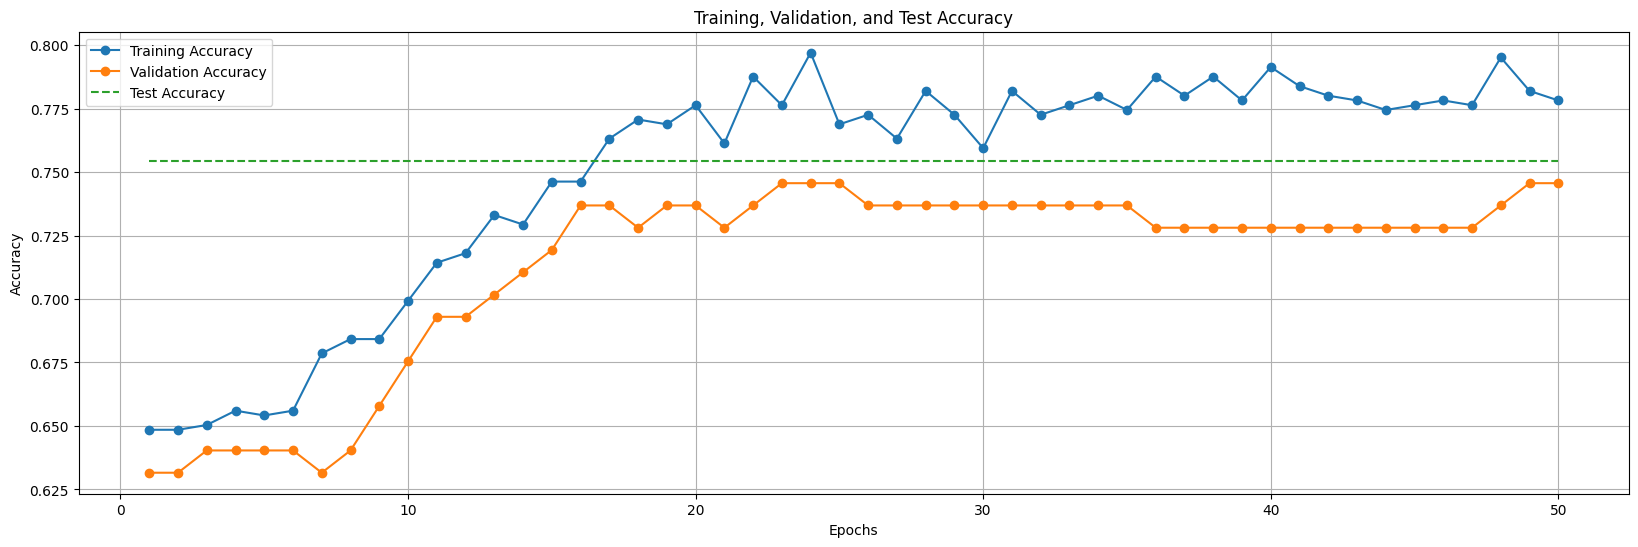

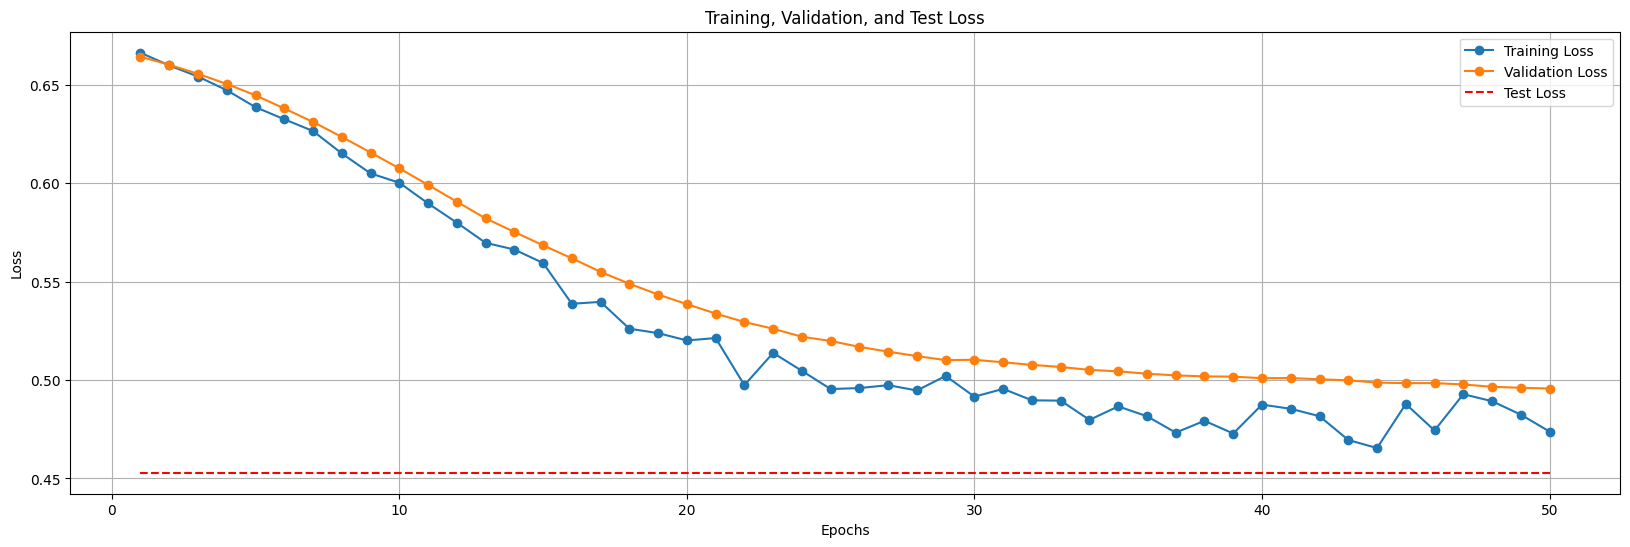

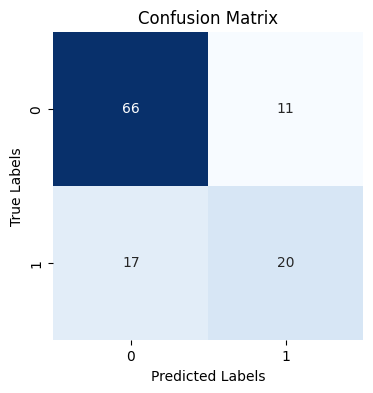

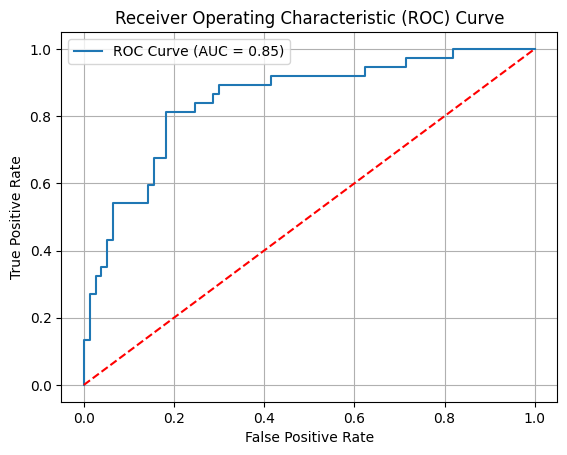

In [10]:
plot_acc(training_details , test_results)
plot_loss(training_details , test_results)
plot_conf_mat(test_results)
plot_roc_curve(test_results)

### Part2

#### Step 1 

In [73]:
learning_rates = [0.0001, 0.0004, 0.0007, 0.001, 0.004, 0.007, 0.01] # Skip the learning rate already used in part 1
accuracy_with_lr = []
test_accuracies = []
#best_model_path = "best_model_lr.pth"

for rate in learning_rates:
    print("\n\n" , "*"*30)
    print(f"Current lr_rate : {rate}")
    model = SimpleNN()
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=rate)
    epochs = 100
    batch_size = 16

    training_details = {
        "train_loss" : [],
        "val_loss_list" : [],
        "val_acc_list" : [],
        "train_acc_list" : []
    }
    train(
        model,
        training_details,
        (X_train_tensor,y_train_tensor),
        (X_val_tensor, y_val_tensor),
        optimizer,
        loss_function,
        epochs=epochs,
        batch_size=batch_size,
        verbose = False
        )
    train_loss , val_loss_list, val_acc_list , train_acc_list = list(training_details.values())
    
    test_results = eval(
        model,
        (X_test_tensor, y_test_tensor),
        loss_function
    )
    
    test_accuracies.append(test_results["acc"])
    accuracy_with_lr.append((rate , test_results["acc"]))
    



 ******************************
Current lr_rate : 0.0001
Parameters : Epcohs 100 | batch_size : 16
Training Complete. Time taken: 1.50 seconds.
Best Validation Accuracy: 0.7632
Test Accuracy: 0.789
Test Precision: 0.710
Test Recall: 0.595
Test F1 Score: 0.647


 ******************************
Current lr_rate : 0.0004
Parameters : Epcohs 100 | batch_size : 16
Training Complete. Time taken: 1.43 seconds.
Best Validation Accuracy: 0.7544
Test Accuracy: 0.763
Test Precision: 0.679
Test Recall: 0.514
Test F1 Score: 0.585


 ******************************
Current lr_rate : 0.0007
Parameters : Epcohs 100 | batch_size : 16
Training Complete. Time taken: 1.41 seconds.
Best Validation Accuracy: 0.7544
Test Accuracy: 0.781
Test Precision: 0.714
Test Recall: 0.541
Test F1 Score: 0.615


 ******************************
Current lr_rate : 0.001
Parameters : Epcohs 100 | batch_size : 16
Training Complete. Time taken: 1.46 seconds.
Best Validation Accuracy: 0.7456
Test Accuracy: 0.754
Test Precision:

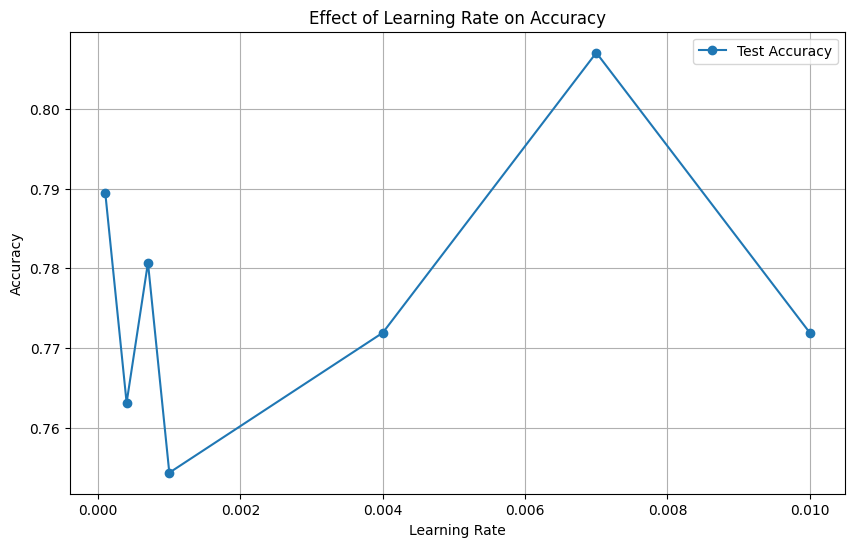

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Effect of Learning Rate on Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
# top 3 learning rates
accuracy_with_lr.sort(key=lambda x: x[1], reverse=True)

# Output the best three setups for learning rates
print("Top 3 Learning Rates with Best Test Accuracy:")
for i in range(3):
    print(f"Learning Rate: {accuracy_with_lr[i][0]}, Test Accuracy: {accuracy_with_lr[i][1]:.4f}")
    
best_lr_rate = accuracy_with_lr[0][0]

Top 3 Learning Rates with Best Test Accuracy:
Learning Rate: 0.007, Test Accuracy: 0.8070
Learning Rate: 0.0001, Test Accuracy: 0.7895
Learning Rate: 0.0007, Test Accuracy: 0.7807


#### Step 2

##### Hyperparameter : Optimizer

In [14]:
optimizers = {
    "SGD" : optim.SGD,
    "Adam" : optim.Adam,
    "RMSprop" : optim.RMSprop,
    "Adagrad" : optim.Adagrad
}

accuracy_with_optim = []
test_accuracies = []
best_model_path = "best_model_lr.pth"

for optim_name , curr_optimizer in optimizers.items():
    print("\n\n" , "*"*30)
    print(f"Current lr_rate : {rate}")
    model = SimpleNN()
    loss_function = nn.BCELoss()
    optimizer = curr_optimizer(model.parameters(), lr=0.001)
    epochs = 100
    batch_size = 16

    training_details = {
        "train_loss" : [],
        "val_loss_list" : [],
        "val_acc_list" : [],
        "train_acc_list" : []
    }
    train(
        model,
        training_details,
        (X_train_tensor,y_train_tensor),
        (X_val_tensor, y_val_tensor),
        optimizer,
        loss_function,
        epochs=epochs,
        batch_size=batch_size,
        verbose = False
        )
    train_loss , val_loss_list, val_acc_list , train_acc_list = list(training_details.values())
    
    test_results = eval(
        model,
        (X_test_tensor, y_test_tensor),
        loss_function
    )
    
    test_accuracies.append(test_results["acc"])
    accuracy_with_optim.append((optim_name , test_results["acc"]))
    



 ******************************
Current lr_rate : 0.01
Parameters : Epcohs 100 | batch_size : 16
Training Complete. Time taken: 1.16 seconds.
Best Validation Accuracy: 0.7018
Test Accuracy: 0.675
Test Precision: 0.000
Test Recall: 0.000
Test F1 Score: 0.000


 ******************************
Current lr_rate : 0.01


/Users/shubby/Desktop/UB/Intro to ML - CSE574/4. Assignment - 2/ML-Project-2/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Parameters : Epcohs 100 | batch_size : 16
Training Complete. Time taken: 1.50 seconds.
Best Validation Accuracy: 0.7544
Test Accuracy: 0.754
Test Precision: 0.645
Test Recall: 0.541
Test F1 Score: 0.588


 ******************************
Current lr_rate : 0.01
Parameters : Epcohs 100 | batch_size : 16
Training Complete. Time taken: 1.29 seconds.
Best Validation Accuracy: 0.7719
Test Accuracy: 0.763
Test Precision: 0.656
Test Recall: 0.568
Test F1 Score: 0.609


 ******************************
Current lr_rate : 0.01
Parameters : Epcohs 100 | batch_size : 16
Training Complete. Time taken: 1.30 seconds.
Best Validation Accuracy: 0.7632
Test Accuracy: 0.816
Test Precision: 0.750
Test Recall: 0.649
Test F1 Score: 0.696


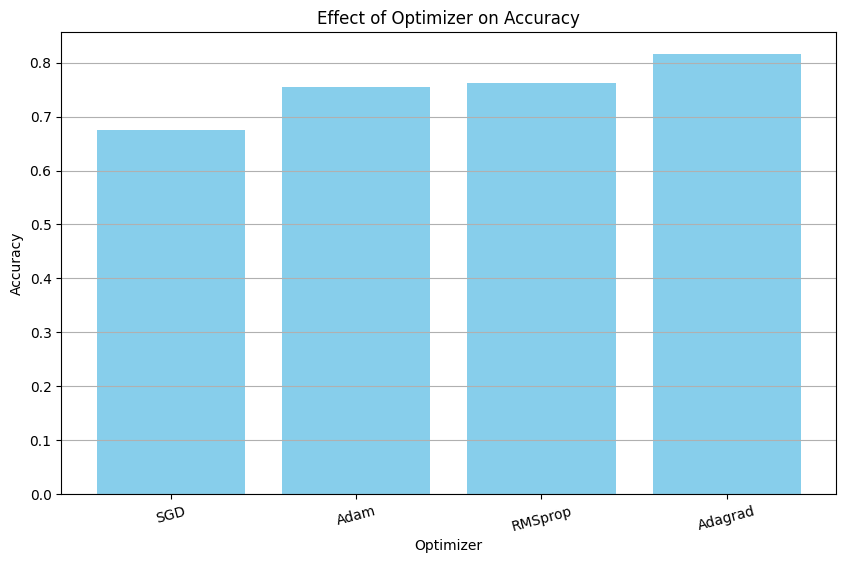

In [17]:
# Plot
plt.figure(figsize=(10, 6))
plt.bar(list(optimizers.keys()) , test_accuracies, color='skyblue')
plt.title('Effect of Optimizer on Accuracy')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()

In [18]:
# top 3 learning rates
accuracy_with_optim.sort(key=lambda x: x[1], reverse=True)

# Output the best three setups for learning rates
print("Top 3 optmizer with Best Test Accuracy:")
for i in range(3):
    print(f" Optimizer: {accuracy_with_optim[i][0]}, Test Accuracy: {accuracy_with_optim[i][1]:.4f}")
    
best_optim = optimizers[accuracy_with_optim[0][0]]

Top 3 optmizer with Best Test Accuracy:
 Optimizer: Adagrad, Test Accuracy: 0.8158
 Optimizer: RMSprop, Test Accuracy: 0.7632
 Optimizer: Adam, Test Accuracy: 0.7544


In [45]:
batch_size_list = [1, 2, 4 , 8  , 16  , 32 ]

accuracy_with_batch = []
test_accuracies = []
#best_model_path = "best_model_lr.pth"

for batch_size in batch_size_list:
    print("\n\n" , "*"*30)
    print(f"batch size : {batch_size}")
    model = SimpleNN()
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 100
    #batch_size = 16

    training_details = {
        "train_loss" : [],
        "val_loss_list" : [],
        "val_acc_list" : [],
        "train_acc_list" : []
    }
    train(
        model,
        training_details,
        (X_train_tensor,y_train_tensor),
        (X_val_tensor, y_val_tensor),
        optimizer,
        loss_function,
        epochs=epochs,
        batch_size=batch_size,
        verbose = False
        )
    train_loss , val_loss_list, val_acc_list , train_acc_list = list(training_details.values())
    
    test_results = eval(
        model,
        (X_test_tensor, y_test_tensor),
        loss_function
    )
    
    test_accuracies.append(test_results["acc"])
    accuracy_with_batch.append((batch_size , test_results["acc"]))
    



 ******************************
batch size : 1
Parameters : Epcohs 100 | batch_size : 1
Training Complete. Time taken: 17.55 seconds.
Best Validation Accuracy: 0.7632
Test Accuracy: 0.711
Test Precision: 0.553
Test Recall: 0.568
Test F1 Score: 0.560


 ******************************
batch size : 2
Parameters : Epcohs 100 | batch_size : 2
Training Complete. Time taken: 9.28 seconds.
Best Validation Accuracy: 0.7632
Test Accuracy: 0.763
Test Precision: 0.632
Test Recall: 0.649
Test F1 Score: 0.640


 ******************************
batch size : 4
Parameters : Epcohs 100 | batch_size : 4
Training Complete. Time taken: 4.79 seconds.
Best Validation Accuracy: 0.7544
Test Accuracy: 0.763
Test Precision: 0.667
Test Recall: 0.541
Test F1 Score: 0.597


 ******************************
batch size : 8
Parameters : Epcohs 100 | batch_size : 8
Training Complete. Time taken: 2.52 seconds.
Best Validation Accuracy: 0.7544
Test Accuracy: 0.772
Test Precision: 0.720
Test Recall: 0.486
Test F1 Score: 0

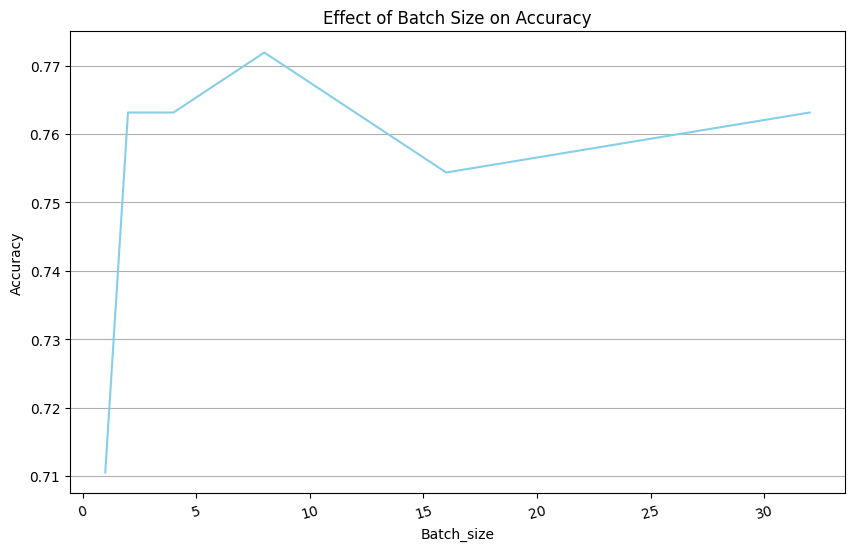

In [46]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(batch_size_list , test_accuracies, color='skyblue')
plt.title('Effect of Batch Size on Accuracy')
plt.xlabel('Batch_size')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()

In [47]:
# top 3 Batch size
accuracy_with_batch.sort(key=lambda x: x[1], reverse=True)

# Output the best three setups for learning rates
print("Top 3 Batch sizes with Best Test Accuracy:")
for i in range(3):
    print(f" Batch Size: {accuracy_with_batch[i][0]}, Test Accuracy: {accuracy_with_batch[i][1]:.4f}")
    
best_batch_size = accuracy_with_batch[0][0]
best_batch_size

Top 3 Batch sizes with Best Test Accuracy:
 Batch Size: 8, Test Accuracy: 0.7719
 Batch Size: 2, Test Accuracy: 0.7632
 Batch Size: 4, Test Accuracy: 0.7632


8

In [55]:

dropout_rate_list = [0.01, 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 ]

accuracy_with_dropout = []
test_accuracies = []
#best_model_path = "best_model_lr.pth"

for drop_rate in dropout_rate_list:
    print("\n\n" , "*"*30)
    print(f"Current dropout_rate : {drop_rate}")
    model = SimpleNN(drop_rate)
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 100
    #batch_size = 16

    training_details = {
        "train_loss" : [],
        "val_loss_list" : [],
        "val_acc_list" : [],
        "train_acc_list" : []
    }
    train(
        model,
        training_details,
        (X_train_tensor,y_train_tensor),
        (X_val_tensor, y_val_tensor),
        optimizer,
        loss_function,
        epochs=epochs,
        batch_size=batch_size,
        verbose = False
        )
    train_loss , val_loss_list, val_acc_list , train_acc_list = list(training_details.values())
    
    test_results = eval(
        model,
        (X_test_tensor, y_test_tensor),
        loss_function
    )
    
    test_accuracies.append(test_results["acc"])
    accuracy_with_dropout.append((drop_rate , test_results["acc"]))
    



 ******************************
Current dropout_rate : 0.01
Parameters : Epcohs 100 | batch_size : 32
Training Complete. Time taken: 0.92 seconds.
Best Validation Accuracy: 0.7544
Test Accuracy: 0.754
Test Precision: 0.645
Test Recall: 0.541
Test F1 Score: 0.588


 ******************************
Current dropout_rate : 0.1
Parameters : Epcohs 100 | batch_size : 32
Training Complete. Time taken: 0.81 seconds.
Best Validation Accuracy: 0.7544
Test Accuracy: 0.754
Test Precision: 0.645
Test Recall: 0.541
Test F1 Score: 0.588


 ******************************
Current dropout_rate : 0.2
Parameters : Epcohs 100 | batch_size : 32
Training Complete. Time taken: 0.82 seconds.
Best Validation Accuracy: 0.7456
Test Accuracy: 0.746
Test Precision: 0.633
Test Recall: 0.514
Test F1 Score: 0.567


 ******************************
Current dropout_rate : 0.3
Parameters : Epcohs 100 | batch_size : 32
Training Complete. Time taken: 0.80 seconds.
Best Validation Accuracy: 0.7544
Test Accuracy: 0.789
Test 

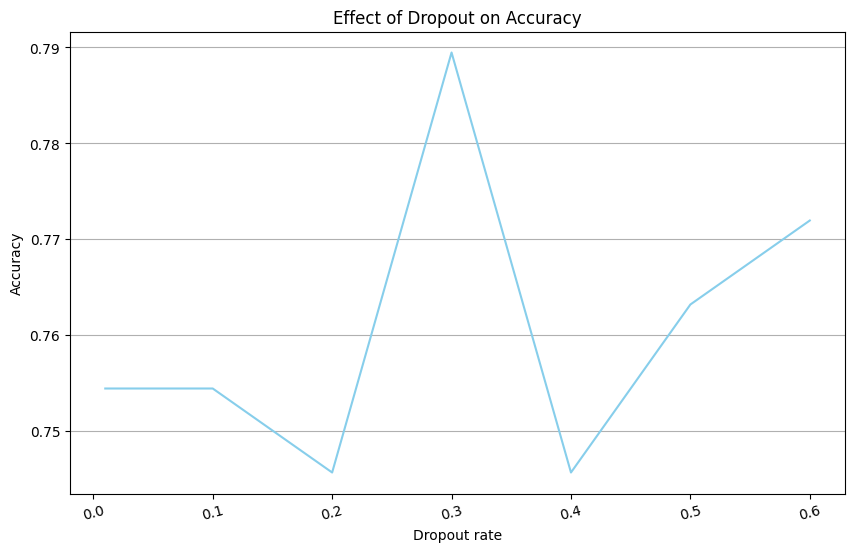

In [56]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(dropout_rate_list , test_accuracies, color='skyblue')
plt.title('Effect of Dropout on Accuracy')
plt.xlabel('Dropout rate')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()

In [69]:
# top 3 Batch size
accuracy_with_dropout.sort(key=lambda x: x[1], reverse=True)

# Output the best three setups for learning rates
print("Top 3 Batch sizes with Best Test Accuracy:")
for i in range(3):
    print(f" Dropout Rate: {accuracy_with_dropout[i][0]}, Test Accuracy: {accuracy_with_dropout[i][1]:.4f}")

best_dropout = accuracy_with_dropout[0][0]

Top 3 Batch sizes with Best Test Accuracy:
 Dropout Rate: 0.3, Test Accuracy: 0.7895
 Dropout Rate: 0.6, Test Accuracy: 0.7719
 Dropout Rate: 0.5, Test Accuracy: 0.7632


### Step 3

In [72]:
print(best_batch_size)
print(best_dropout)
print(best_lr_rate)

8
0.3
0.0001


In [99]:
epochs = 50
batch_size = best_batch_size
drop_rate = best_dropout
lr_rate = best_lr_rate

model = SimpleNN(drop_rate)
loss_function = nn.BCELoss()
optimizer = best_optim(model.parameters(), lr=lr_rate)


training_details = {
    "train_loss" : [],
    "val_loss_list" : [],
    "val_acc_list" : [],
    "train_acc_list" : []
}
train(
    model,
    training_details,
    (X_train_tensor,y_train_tensor),
    (X_val_tensor, y_val_tensor),
    optimizer,
    loss_function,
    epochs=epochs,
    batch_size=batch_size,
    verbose = False
    )
train_loss , val_loss_list, val_acc_list , train_acc_list = list(training_details.values())

test_results = eval(
    model,
    (X_test_tensor, y_test_tensor),
    loss_function
)

Parameters : Epcohs 50 | batch_size : 8
Training Complete. Time taken: 1.13 seconds.
Best Validation Accuracy: 0.7544
Test Accuracy: 0.763
Test Precision: 0.679
Test Recall: 0.514
Test F1 Score: 0.585


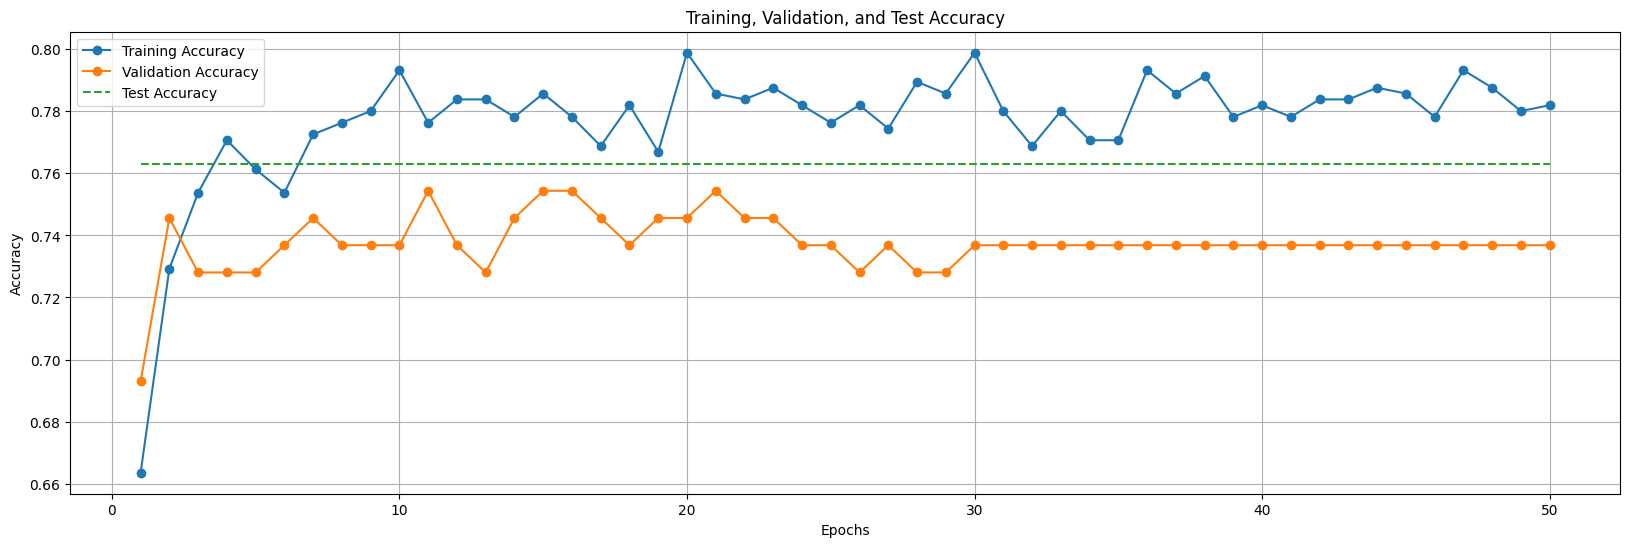

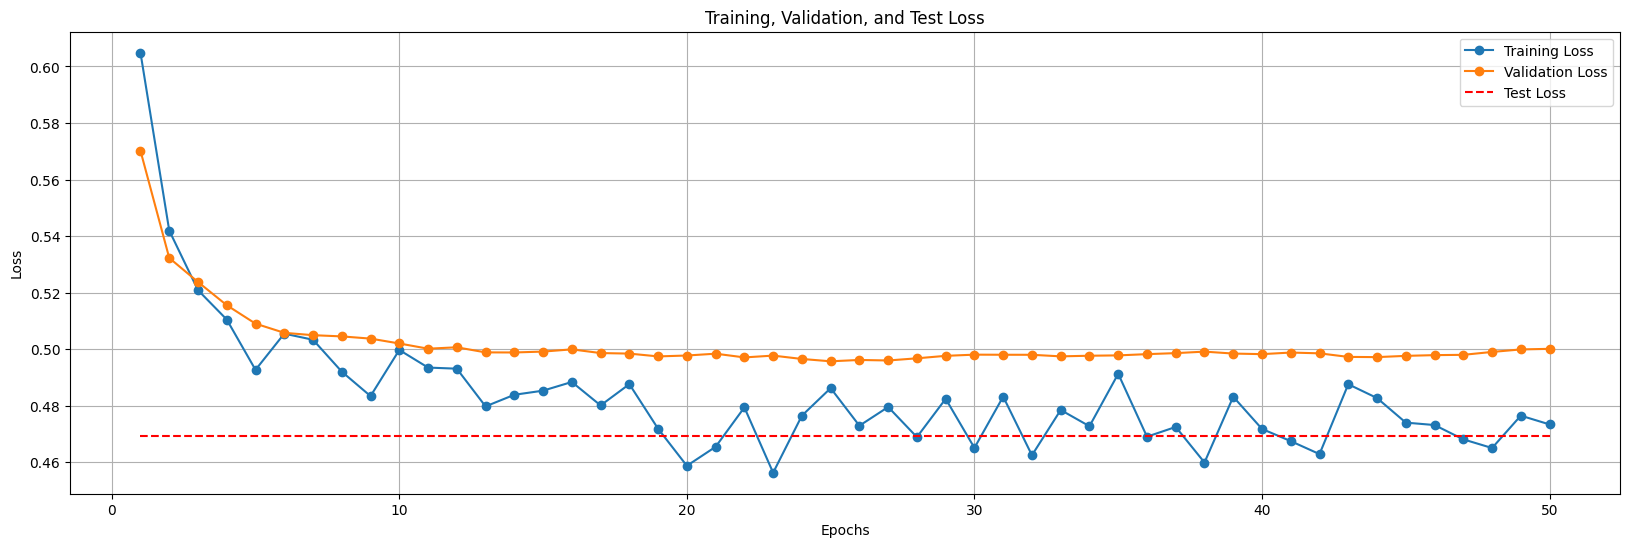

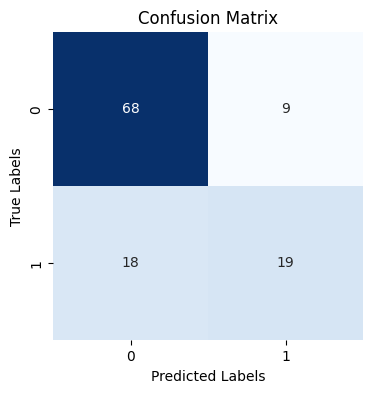

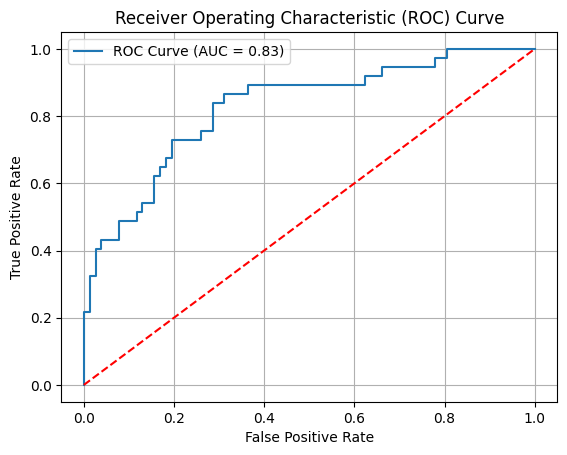

In [100]:
plot_acc(training_details , test_results)
plot_loss(training_details , test_results)
plot_conf_mat(test_results)
plot_roc_curve(test_results)

In [101]:
torch.save(model , "base_model.pth")

In [102]:
### Step 4

### Step 4

#### Method 1 : Batch Normalization

In [103]:
class SimpleNNBatchNorm(nn.Module):
    def __init__(self , dropout_val = 0.2):
        super(SimpleNNBatchNorm, self).__init__()
        self.fc1 = nn.Linear(7, 64)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.batch_norm1 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 32)
        self.batch_norm1 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)

        self.dropout = nn.Dropout(dropout_val)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))  # Output layer with Sigmoid activation
        return x

# Instantiate the model
model = SimpleNNBatchNorm()

# Display a summary of the model
summary(model, input_size=(1, 7))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleNNBatchNorm                        [1, 1]                    64
├─Linear: 1-1                            [1, 64]                   512
├─Dropout: 1-2                           [1, 64]                   --
├─Linear: 1-3                            [1, 32]                   2,080
├─Dropout: 1-4                           [1, 32]                   --
├─Linear: 1-5                            [1, 32]                   1,056
├─Linear: 1-6                            [1, 1]                    33
Total params: 3,745
Trainable params: 3,745
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02

In [105]:
epochs = 50
batch_size = best_batch_size
drop_rate = best_dropout
lr_rate = best_lr_rate

model = SimpleNNBatchNorm(drop_rate)
loss_function = nn.BCELoss()
optimizer = best_optim(model.parameters(), lr=lr_rate)


training_details = {
    "train_loss" : [],
    "val_loss_list" : [],
    "val_acc_list" : [],
    "train_acc_list" : []
}
train(
    model,
    training_details,
    (X_train_tensor,y_train_tensor),
    (X_val_tensor, y_val_tensor),
    optimizer,
    loss_function,
    epochs=epochs,
    batch_size=batch_size,
    verbose = False
    )
train_loss , val_loss_list, val_acc_list , train_acc_list = list(training_details.values())

test_results = eval(
    model,
    (X_test_tensor, y_test_tensor),
    loss_function
)

Parameters : Epcohs 50 | batch_size : 8
Training Complete. Time taken: 1.08 seconds.
Best Validation Accuracy: 0.7456
Test Accuracy: 0.772
Test Precision: 0.667
Test Recall: 0.595
Test F1 Score: 0.629


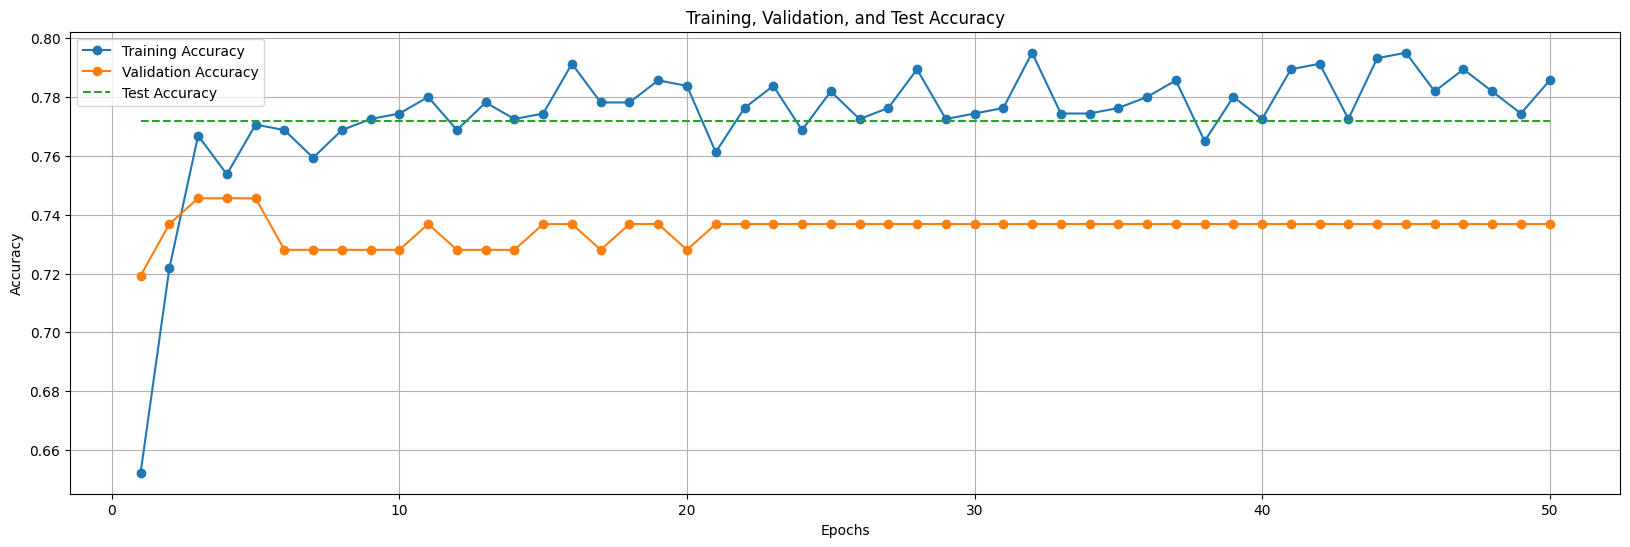

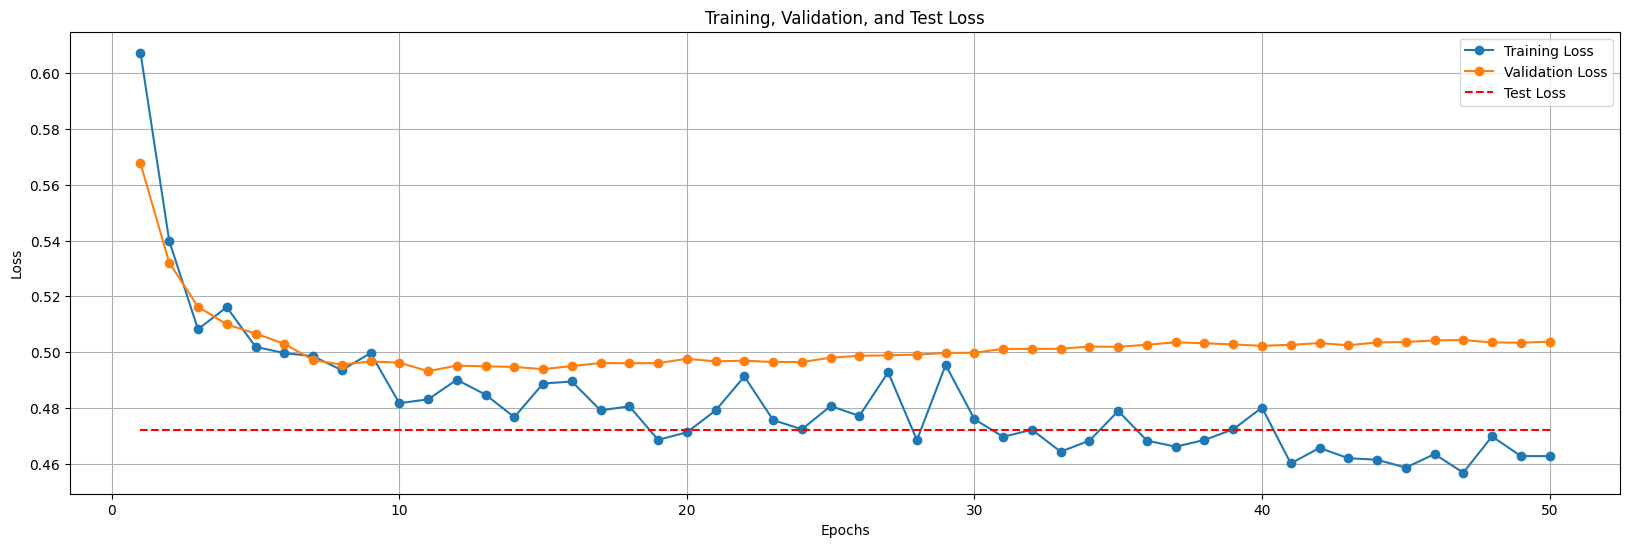

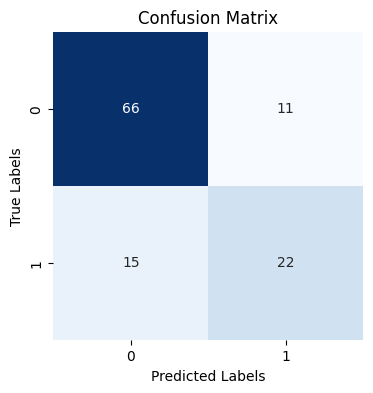

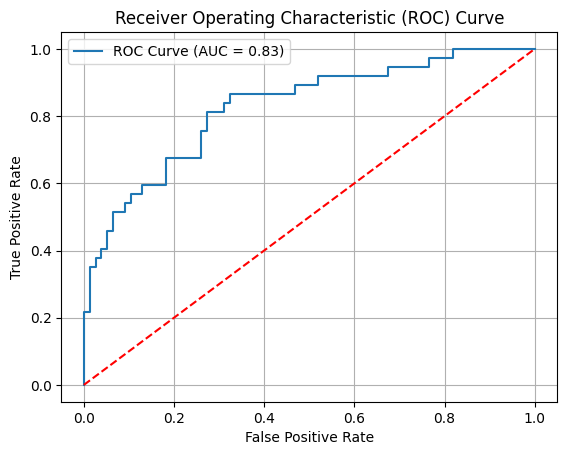

In [106]:
plot_acc(training_details , test_results)
plot_loss(training_details , test_results)
plot_conf_mat(test_results)
plot_roc_curve(test_results)

#### Method 2: K-Fold

In [107]:
from sklearn.model_selection import KFold

In [108]:
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=19)

In [109]:
new_X_train = torch.cat( (X_train_tensor , X_val_tensor))
new_Y_train = torch.cat( (y_train_tensor , y_val_tensor))

print(f"Shape of new X train {new_X_train.shape}")
print(f"Shape of new Y train {new_Y_train.shape}")

Shape of new X train torch.Size([646, 7])
Shape of new Y train torch.Size([646, 1])


In [120]:
def train_default(train_data ,val_data , test_data):
    epochs = 50
    batch_size = best_batch_size
    drop_rate = best_dropout
    lr_rate = best_lr_rate

    model = SimpleNN(drop_rate)
    loss_function = nn.BCELoss()
    optimizer = best_optim(model.parameters(), lr=lr_rate)


    training_details = {
        "train_loss" : [],
        "val_loss_list" : [],
        "val_acc_list" : [],
        "train_acc_list" : []
    }
    train(
        model,
        training_details,
        train_data,
        val_data,
        optimizer,
        loss_function,
        epochs=epochs,
        batch_size=batch_size,
        verbose = False
        )
    train_loss , val_loss_list, val_acc_list , train_acc_list = list(training_details.values())

    test_results = eval(
        model,
        test_data,
        loss_function
    )
    return test_results


In [121]:
accuracy_list = []
f1_score_list = []

for  i , (train_index, test_index) in enumerate(kf.split(new_X_train)):
    
    print(f"{i+1} Fold")
    
    x_train, x_val = new_X_train[train_index], new_X_train[test_index]
    y_train, y_val = new_Y_train[train_index], new_Y_train[test_index]
    
    test_result = train_default(
        (x_train , y_train),
        (x_val , y_val ),
        (X_test_tensor, y_test_tensor)
    )
    curr_acc = test_result["acc"]
    curr_f1 = test_result["f1"]
    
    print(f"Accuracy : {curr_acc} | F1 Score : {curr_f1}")
    
    accuracy_list.append(curr_acc)
    f1_score_list.append(curr_f1)

    
    
    

1 Fold
Parameters : Epcohs 50 | batch_size : 8
Training Complete. Time taken: 1.26 seconds.
Best Validation Accuracy: 0.8000
Test Accuracy: 0.754
Test Precision: 0.629
Test Recall: 0.595
Test F1 Score: 0.611
Accuracy : 0.7543859649122807 | F1 Score : 0.6111111111111112
2 Fold
Parameters : Epcohs 50 | batch_size : 8
Training Complete. Time taken: 1.22 seconds.
Best Validation Accuracy: 0.8000
Test Accuracy: 0.772
Test Precision: 0.657
Test Recall: 0.622
Test F1 Score: 0.639
Accuracy : 0.7719298245614035 | F1 Score : 0.6388888888888888
3 Fold
Parameters : Epcohs 50 | batch_size : 8
Training Complete. Time taken: 1.18 seconds.
Best Validation Accuracy: 0.7538
Test Accuracy: 0.781
Test Precision: 0.700
Test Recall: 0.568
Test F1 Score: 0.627
Accuracy : 0.7807017543859649 | F1 Score : 0.6268656716417911
4 Fold
Parameters : Epcohs 50 | batch_size : 8
Training Complete. Time taken: 1.23 seconds.
Best Validation Accuracy: 0.6615
Test Accuracy: 0.763
Test Precision: 0.656
Test Recall: 0.568
Tes

In [122]:
print(f"Average Accuracy in {k} Fold : {np.mean(accuracy_list)} " )
print(f"Average F1_score in {k} Fold : {np.mean(f1_score_list)} " )

Average Accuracy in 10 Fold : 0.7666666666666667 
Average F1_score in 10 Fold : 0.6166061817329138 


#### Method 3 : Data augmentation

In [123]:
noise_frac = 0.3
noise_size = int(noise_frac*X_train.shape[0])
feature_size = X_train.shape[1]
noise_shape = ( noise_size , feature_size )
noise_data = torch.zeros(noise_shape)


mean_t = X_train_tensor.mean(axis = 0)
std_t = X_train_tensor.std(axis = 0)


noise_list = []

for i in range(feature_size):
    feat_i_noise = torch.normal( mean_t[i]  , std_t[i] , (noise_size , ))
    noise_data[: , i] = feat_i_noise
    
    
    
Noisy_X_train_tensor = torch.concat((X_train_tensor , noise_data)) 

Noisy_y_train_tensor = torch.concat((y_train_tensor , torch.randint(0 , 2 , (noise_size , 1))))


In [124]:
epochs = 100
batch_size = best_batch_size
drop_rate = best_dropout
lr_rate = best_lr_rate

model = SimpleNN(drop_rate)
loss_function = nn.BCELoss()
optimizer = best_optim(model.parameters(), lr=lr_rate)


training_details = {
    "train_loss" : [],
    "val_loss_list" : [],
    "val_acc_list" : [],
    "train_acc_list" : []
}
train(
    model,
    training_details,
    (Noisy_X_train_tensor,Noisy_y_train_tensor),
    (X_val_tensor, y_val_tensor),
    optimizer,
    loss_function,
    epochs=epochs,
    batch_size=batch_size,
    verbose = False
    )
train_loss , val_loss_list, val_acc_list , train_acc_list = list(training_details.values())

test_results = eval(
    model,
    (X_test_tensor, y_test_tensor),
    loss_function
)

Parameters : Epcohs 100 | batch_size : 8
Training Complete. Time taken: 2.88 seconds.
Best Validation Accuracy: 0.7632
Test Accuracy: 0.789
Test Precision: 0.676
Test Recall: 0.676
Test F1 Score: 0.676


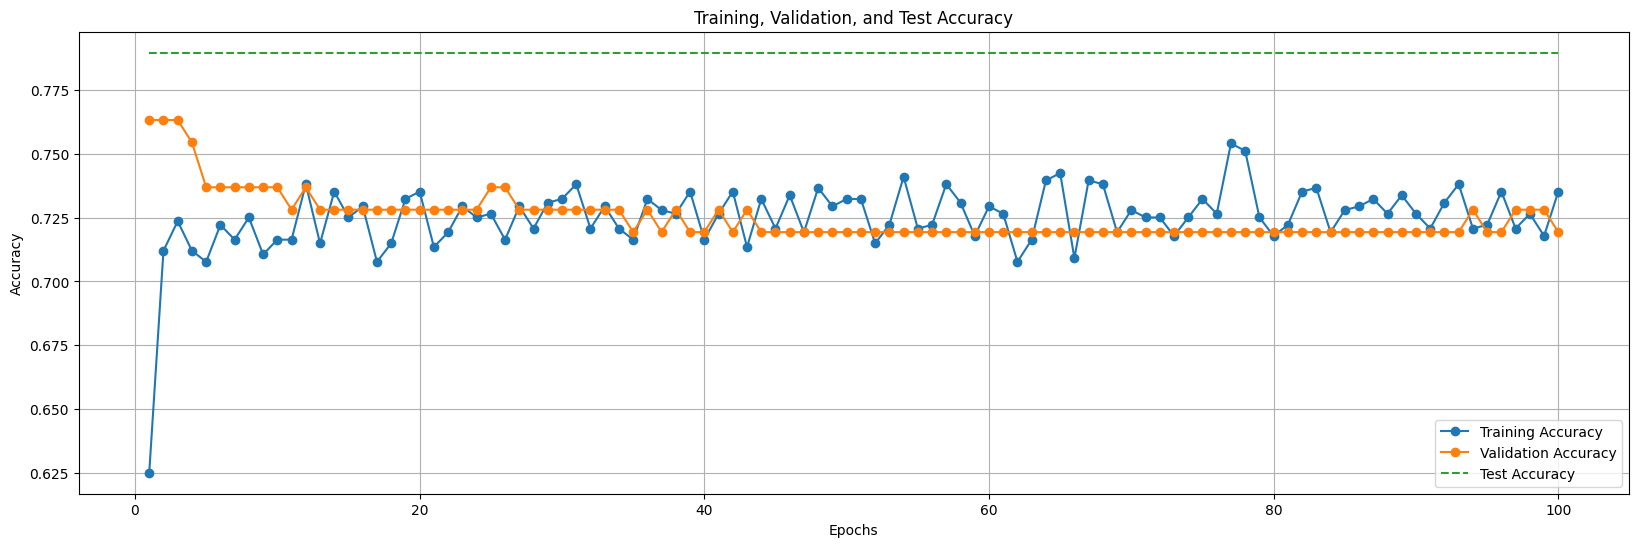

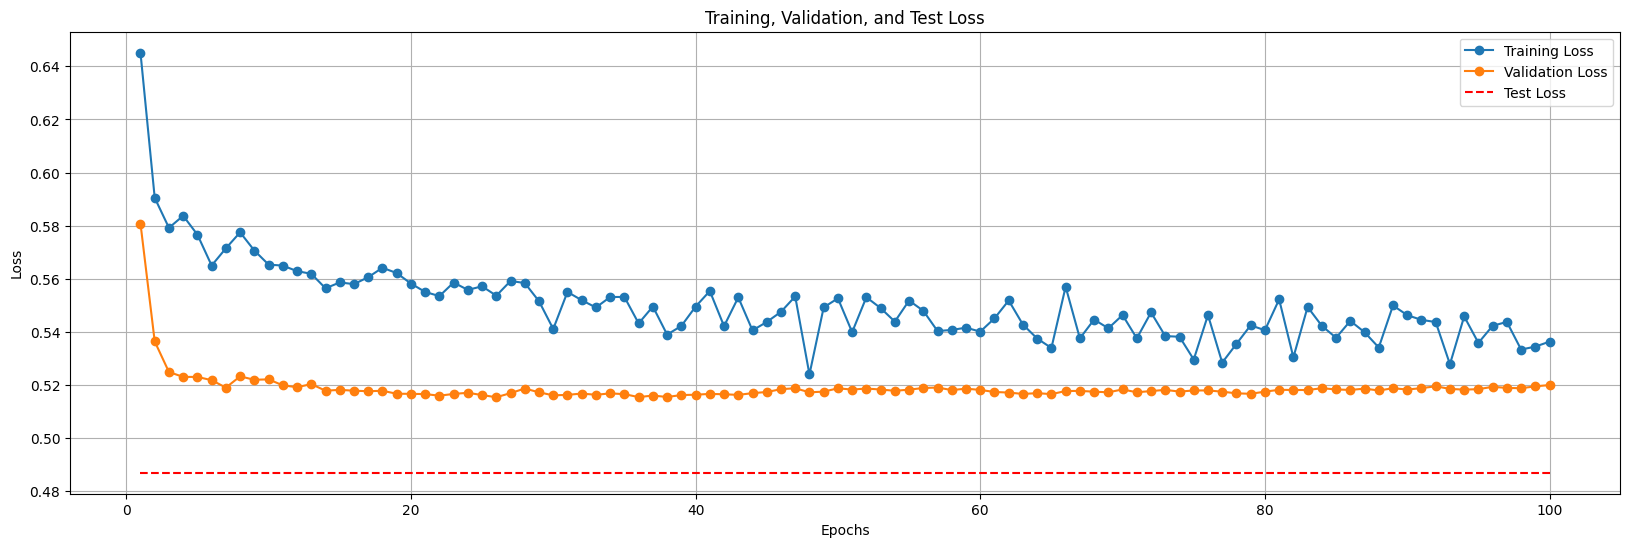

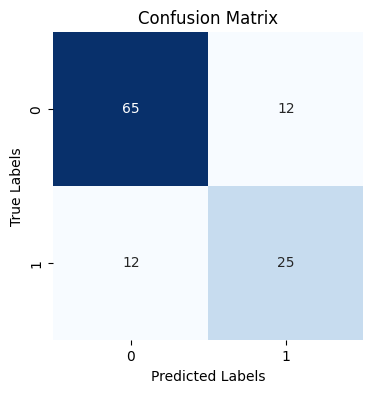

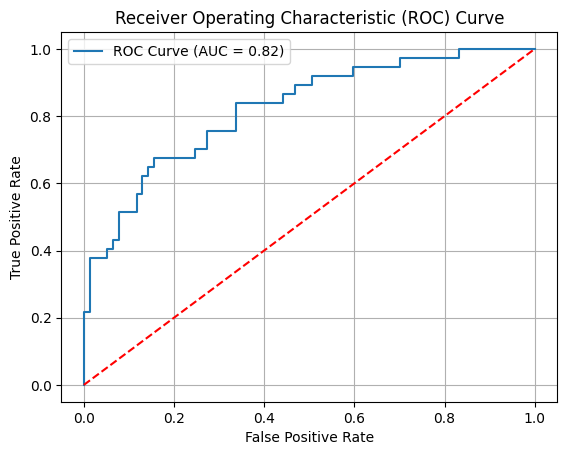

In [125]:
plot_acc(training_details , test_results)
plot_loss(training_details , test_results)
plot_conf_mat(test_results)
plot_roc_curve(test_results)

#### Method 4 : Gradient Accumulation

In [132]:
ga_values = [2,3,4,5,6,7,8]
accuracy_list = []
f1_score_list = []

for ga_size in ga_values:
    epochs = 100
    batch_size = best_batch_size
    drop_rate = best_dropout
    lr_rate = best_lr_rate

    model = SimpleNN(drop_rate)
    loss_function = nn.BCELoss()
    optimizer = best_optim(model.parameters(), lr=lr_rate)


    training_details = {
        "train_loss" : [],
        "val_loss_list" : [],
        "val_acc_list" : [],
        "train_acc_list" : []
    }
    train(
        model,
        training_details,
        (X_train_tensor,y_train_tensor),
        (X_val_tensor, y_val_tensor),
        optimizer,
        loss_function,
        epochs=epochs,
        batch_size=batch_size,
        verbose = False,
        gradient_accumulation=ga_size
        )
    train_loss , val_loss_list, val_acc_list , train_acc_list = list(training_details.values())

    test_results = eval(
        model,
        (X_test_tensor, y_test_tensor),
        loss_function,
        verbose=False
    )
    
    curr_acc = test_results["acc"]
    curr_f1 = test_results["f1"]
    print("\n\n*****************************************")
    print(f"GA_size : {ga_size}")
    print(f"Accuracy : {curr_acc} | F1 Score : {curr_f1}")
    print("*****************************************")
    
    accuracy_list.append(curr_acc)
    f1_score_list.append(curr_f1)

Parameters : Epcohs 100 | batch_size : 8
Training Complete. Time taken: 1.89 seconds.
Best Validation Accuracy: 0.7632


*****************************************
GA_size : 2
Accuracy : 0.7719298245614035 | F1 Score : 0.6176470588235294
*****************************************
Parameters : Epcohs 100 | batch_size : 8
Training Complete. Time taken: 1.72 seconds.
Best Validation Accuracy: 0.7719


*****************************************
GA_size : 3
Accuracy : 0.7631578947368421 | F1 Score : 0.5846153846153846
*****************************************
Parameters : Epcohs 100 | batch_size : 8
Training Complete. Time taken: 1.70 seconds.
Best Validation Accuracy: 0.7632


*****************************************
GA_size : 4
Accuracy : 0.7894736842105263 | F1 Score : 0.6363636363636364
*****************************************
Parameters : Epcohs 100 | batch_size : 8
Training Complete. Time taken: 1.61 seconds.
Best Validation Accuracy: 0.7456


*****************************************


In [133]:
print(f"Average Accuracy : {np.mean(accuracy_list)} " )
print(f"Average F1_score : {np.mean(f1_score_list)} " )

Average Accuracy : 0.7794486215538848 
Average F1_score : 0.625172291022661 
